In [37]:
# !pip install openai
# !pip install tweepy

In [38]:
import tweepy
import pandas as pd
import openai
import time
import os
from datetime import datetime

# Api Secret key

In [39]:
with open("api_keys.txt", 'r', encoding='utf-8') as api_file:
    api_keys = api_file.readlines()

for key in api_keys:
    if "bearer_token" in key:
        twitter_api_key = key.split('"')[1]
    elif "openai_token" in key:
        openai_api_key = key.split('"')[1]
        

# Scrapping tweet data

In [40]:
def get_tweets_by_handle(handle, api_key, start_time, end_time, tweets):
    client = tweepy.Client(bearer_token=twitter_api_key, wait_on_rate_limit=True)
    user_id = client.get_user(username=handle).data.id
    tweets_data = client.get_users_tweets(id=user_id, max_results=100, start_time=start_time, end_time=end_time,
                                          tweet_fields=['id', 'text', 'created_at', 'context_annotations']).data

    
    for tweet in tweets_data: 
        tweets['handle'].append(handle)
        tweets['tweet'].append(tweet.text)
        tweets['id'].append(tweet.id)

# Label tweet with OpenAI

In [41]:
def check_sentiment_from_tweet(tweet: str, api_key: str) -> bool:
    openai.api_key = api_key
    prompt_text = tweet + ' is positive. True or False?'
    response = openai.Completion.create(model="text-ada-001", 
                                        prompt=prompt_text, 
                                        temperature=0, n=1,
                                        max_tokens=256).choices[0].text
    time.sleep(7)
    if 'true' in response.lower() or 'positive' in response.lower():
        return True
    else:
        return False

In [42]:
# tweets = pd.read_csv('data_tweet.csv')
# tweets = pd.DataFrame(tweets['text'])

In [43]:
# length_tweets = 3000

# tweets = tweets[:length_tweets]

In [44]:
# tweets['sentiment'] = tweets['text'].apply(lambda x: check_sentiment_from_tweet(x, openai_api_key))

#### export tweet data to csv

In [45]:
# tweets.to_csv('tweet_data.csv', index=False)

# Preprocessing

In [46]:
import numpy as np
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [47]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kuro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kuro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kuro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
def process_data(data):
    documents = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(data)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(data[sen]))    
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)    
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)    
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)    
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)    
        # Converting to Lowercase
        document = document.lower()    
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)    
        documents.append(document)
    return documents

In [49]:
df = pd.read_csv('tweet_data.csv')
df.head()

,text,sentiment
0,in other news..... whats the 3-day sales analy...,True
1,"At this point, I don't know where the Blu eCig...",False
2,Frustrating! Everyone should support the switc...,True
3,Alternative Medicine: Blu eCig promotes 'freed...,False
4,.@njoyecigs welcomes new ecig regulations --&g...,False


In [52]:
y = df['sentiment']
X = df['text']

In [53]:
text_arr = process_data(X)

In [54]:
tfidfconverter = TfidfVectorizer(max_features=1500, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(text_arr).toarray()

# EDA

<AxesSubplot:>

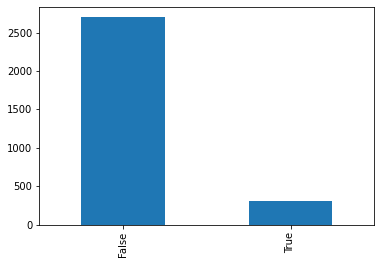

In [55]:
df['sentiment'].value_counts().plot(kind='bar')

In [56]:
print("There are %i corpus" %(len(text_arr)))
print("Percentage of positive corpus:", (len(df[df['sentiment']==True])))
print("Percentage of negative corpus", (len(df[df['sentiment']==False])))

There are 3000 corpus
Percentage of positive corpus: 303
Percentage of negative corpus 2697


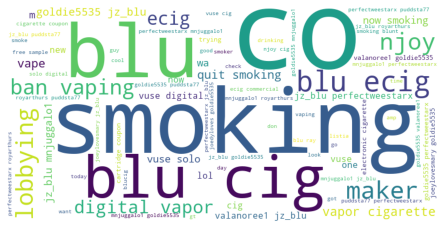

In [57]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(' '.join(text_arr))

plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

# Machine learning

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

In [59]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

#### Confusion matrix

In [60]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

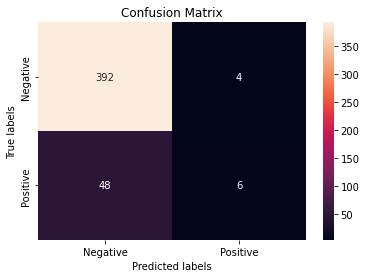

In [61]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);
ax.set_title('Confusion Matrix');

#### Calculate precision, recall and f1-score

In [62]:
print("Report model\n")
print(classification_report(y_pred, y_test))

Report model

              precision    recall  f1-score   support

       False       0.99      0.89      0.94       440
        True       0.11      0.60      0.19        10

    accuracy                           0.88       450
   macro avg       0.55      0.75      0.56       450
weighted avg       0.97      0.88      0.92       450

